Поковырявшись в полноценной в смысле наличия нейтральных отзывов задаче, начало казаться, что всё не так либо с нейтральными отзывами, либо с негативными, либо и с теми, и с другими. Цель сего блокнота состоит в выяснении 

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gc
import datetime
import matplotlib
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Bidirectional, Flatten, Dropout, BatchNormalization, Embedding
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy.random import default_rng
from tensorflow.keras import regularizers

In [2]:
import pickle
with open(r'additional_data\vocab_tokenized_reviews.pickle', 'rb') as tr_file, \
     open(r'additional_data\targets.npy', 'rb') as targets_file, \
     open(r'additional_data\max_len.pickle', 'rb') as ml_file, \
     open(r'additional_data\vocab.pickle', 'rb') as vocab_file:
    
    tokenized_reviews = np.array(pickle.load(tr_file), dtype = np.int32)
    targets = tf.one_hot(np.load(targets_file), 3, dtype = tf.int8).numpy()
    vocabulary = pickle.load(vocab_file)
    MAX_LEN = pickle.load(ml_file)

In [3]:
gc.collect()

11

Убираем нейтральные отзывы

In [4]:
tokenized_reviews = tokenized_reviews[targets[:, 1] != 1]
targets = targets[targets[:, 1] != 1]
targets = np.delete(targets, 1, 1)

Разобьём всю выборку на тренировочную, валидационную и тестовую в соотношении 60/20/20 

In [6]:
X_train, X, y_train, y = train_test_split(tokenized_reviews, targets, test_size = 0.4, stratify = targets)
del tokenized_reviews, targets

X_test, X_val, y_test, y_val = train_test_split(X, y, test_size = 0.5, stratify = y)
del X, y

Объявим парочку классов-генераторов для, собственно, генерации мини-батчей

In [7]:
class BalancedBatchGenerator:
    '''
    Генерирует сбалансированные мини-батчи поочерёдно выдавая негативные и 
    положительные отзывы в случайном порядке до тех пор, пока отзывы одной из категорий не закончатся.
    Таким образом, если X - кол-во представителей самого малочисленного класса, то на каждой эпохе модели
    будет предоставляться по Х случайных элементов каждого класса 
    
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.rng = np.random.default_rng(42)
        
    def __iter__(self):
        inds = np.arange(len(self.X), dtype = 'int32')
        self.neg_inds = inds[self.y[:, 0] == 1]
        self.pos_inds = inds[self.y[:, 1] == 1]
        self.rng.shuffle(self.neg_inds)
        self.rng.shuffle(self.pos_inds)
        
        self.i = -1
        self.neg_i = -1
        self.pos_i = -1
        self.iter_num = min(len(self.neg_inds), len(self.pos_inds))
        return self
    
    def __next__(self):
        self.i += 1
        if (self.neg_i >= self.iter_num - 1 or 
            self.pos_i >= self.iter_num - 1):
            raise StopIteration
        if self.i % 2 == 0:
            self.neg_i += 1
            ind = self.neg_inds[self.neg_i]
            return (self.X[ind], self.y[ind])
        if self.i % 2 == 1:
            self.pos_i += 1 
            ind = self.pos_inds[self.pos_i]
            return (self.X[ind], self.y[ind])

        raise StopIteration 

In [8]:
class BatchGenerator:
    '''
    Генерирует обыкновенные мини-батчи, постепенно выдавая всю выборку
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.rng = np.random.default_rng(42)
        
    def __iter__(self):
        self.inds = np.arange(len(self.X), dtype = 'int32')
        self.rng.shuffle(self.inds)
        self.i = -1
        return self
    
    def __next__(self):
        self.i += 1
        if self.i < len(self.inds):
            return (self.X[self.inds[self.i]], self.y[self.inds[self.i]])
        raise StopIteration 


In [9]:
def one_hot_to_labels(arr):
    pos_to_label = {0: 'neg',
                    1: 'pos'}
    out = []
    for el in arr:
        out.append(pos_to_label[el.argmax()])
    return out

In [10]:
def get_datasets(train, test, val, generators, out_sign, batch_size):
    tf_train = tf.data.Dataset.from_generator(generators[0], args = train,
                                              output_signature = out_sign)
    tf_test = tf.data.Dataset.from_generator(generators[1], args = test,
                                             output_signature = out_sign)
    tf_val = tf.data.Dataset.from_generator(generators[2], args = val,
                                            output_signature = out_sign)
    
    return tf_train.batch(batch_size), tf_test.batch(batch_size), tf_val.batch(batch_size)

In [11]:
BATCH_SIZE = 256

output_signature = (tf.TensorSpec(shape = (MAX_LEN), dtype = tf.float64),
                    tf.TensorSpec(shape = (2), dtype = tf.int8))

tf_train, tf_test, tf_val = get_datasets((X_train, y_train), (X_test, y_test), (X_val, y_val),
                                          generators = [BatchGenerator, BatchGenerator, BatchGenerator],
                                          out_sign = output_signature, batch_size = BATCH_SIZE)


In [13]:
val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

CALLBACKS = [val_loss_callback]

In [14]:
METRICS = ['accuracy', 
           tf.keras.metrics.Recall(class_id = 0, name = 'r_neg'),
           tf.keras.metrics.Recall(class_id = 1, name = 'r_pos'),
           tf.keras.metrics.Precision(class_id = 0, name = 'p_neg'),
           tf.keras.metrics.Precision(class_id = 1, name = 'p_pos')]

In [15]:
neg, pos = (y_train[:, 0] == 1).sum(), (y_train[:, 1] == 1).sum()
_sum = neg + pos
CLASS_WEIGHTS = {0: (1 / neg) * (_sum / 2),
                 1: (1 / pos) * (_sum / 2)}
CLASS_WEIGHTS

{0: 2.6975033624747815, 1: 0.6137654686991948}

Ну и осталось написать функцию, что услужливо нарисует нам красивые графики по итогам обучения

In [28]:
# Эти параметры должны быть такими, чтоб графики выглядили более сносно.
# Размер шрифта цифр у осей
matplotlib.rcParams.update({'font.size': 70})
# Ширина линий, что составляют графики
matplotlib.rcParams.update({'lines.linewidth': 10})

def plot_train_info(history, num_epochs):
    epochs = [i for i in range(1, num_epochs + 1)]
    fig , ax = plt.subplots(3, 2)
    
    train_acc = history['accuracy']
    train_loss = history['loss']
    
    val_acc = history['val_accuracy']
    val_loss = history['val_loss']
    
    train_r_neg = history['r_neg']
    train_r_pos = history['r_pos']
    
    train_p_neg = history['p_neg']
    train_p_pos = history['p_pos']

    val_r_neg = history['val_r_neg']
    val_r_pos = history['val_r_pos']
    
    val_p_neg = history['val_p_neg']
    val_p_pos = history['val_p_pos']
    
    fig.set_size_inches(100, 100)
    
    ax[0, 0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0, 0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0, 0].set_title('Training & Validation Accuracy')
    ax[0, 0].legend()
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].set_ylabel('Accuracy')

    ax[0, 1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[0, 1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[0, 1].set_title('Testing Accuracy & Loss')
    ax[0, 1].legend()
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].set_ylabel('Training & Validation Loss')
    
    ax[1, 0].plot(epochs, train_r_neg , 'g-o' , label = 'Training neg recall')
    ax[1, 0].plot(epochs, train_r_pos, 'r-o' , label = 'Training pos recall')
    ax[1, 0].set_title('Training recalls')
    ax[1, 0].legend()
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].set_ylabel('Recall')
    
    ax[1, 1].plot(epochs, train_p_neg , 'g-o' , label = 'Training neg precision')
    ax[1, 1].plot(epochs, train_p_pos, 'r-o' , label = 'Training pos precision')
    ax[1, 1].set_title('Training precisions')
    ax[1, 1].legend()
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].set_ylabel('Presicion')
    
    ax[2, 0].plot(epochs, val_r_neg , 'g-o' , label = 'Validations neg recall')
    ax[2, 0].plot(epochs, val_r_pos, 'r-o' , label = 'Validations pos recall')
    ax[2, 0].set_title('Validation recalls')
    ax[2, 0].legend()
    ax[2, 0].set_xlabel('Epochs')
    ax[2, 0].set_ylabel('Recall')
    
    ax[2, 1].plot(epochs, val_p_neg , 'g-o' , label = 'Validations neg precision')
    ax[2, 1].plot(epochs, val_p_pos, 'r-o' , label = 'Validations pos precision')
    ax[2, 1].set_title('Validation precisions')
    ax[2, 1].legend()
    ax[2, 1].set_xlabel('Epochs')
    ax[2, 1].set_ylabel('Presicion')
    
    plt.show()

# Непосредственно сеть

In [17]:
model = Sequential([Embedding(input_dim = (len(vocabulary)), output_dim = (25), mask_zero = True),
                    Bidirectional(LSTM(150, activation = 'tanh', name = 'bi_lstm_1', 
                                  return_sequences = True, dropout = 0.85), input_shape = (MAX_LEN, 25)),
                    BatchNormalization(),
                    LSTM(75, activation = 'tanh', name = 'lstm_1', 
                         return_sequences = False, dropout = 0.85),
                    BatchNormalization(),
                    Flatten(),
                    Dense(75, name = 'dense_2', activation = 'relu'),
                    BatchNormalization(),
                    Dropout(0.85),
                    Dense(2, name = 'dense_out', activation = 'softmax')], name = 'WithEmbeddings')

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy',
              metrics = METRICS)
model.summary()

Model: "WithEmbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 25)          5069800   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 300)         211200    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 300)         1200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 75)                112800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 75)                300       
_________________________________________________________________
flatten (Flatten)            (None, 75)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 75)             

In [18]:
# steps_per_epoch = min(y_train[y_train[:, 0] == 1].sum(), y_train[y_train[:, 1] == 1].sum())
# steps_per_epoch *= 2

def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%d %m %Y-%H%M")    
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = 'logs/fit', histogram_freq = 1)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath = r'saved_models\2_classes\1st_ep{epoch:02d}_v_l_{val_loss:.2f}.hdf5',
                            save_best_only = False)

history = model.fit(tf_train.repeat(), steps_per_epoch = len(y_train) // BATCH_SIZE,
                    validation_data = tf_val.repeat(), validation_steps = len(y_val) // BATCH_SIZE,
                    epochs = 25, 
                    callbacks = CALLBACKS + [tensorboard_callback, model_checkpoint_callback, lr_callback],
                    class_weight = CLASS_WEIGHTS)
model.save(r'models\with_bigger_drout_1st_model.h5')

Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
250/250 [==============================] - 1631s 6s/step - loss: 1.1061 - accuracy: 0.4997 - r_neg: 0.5002 - r_pos: 0.4996 - p_neg: 0.1852 - p_pos: 0.8146 - val_loss: 0.6935 - val_accuracy: 0.4568 - val_r_neg: 0.6701 - val_r_pos: 0.4083 - val_p_neg: 0.2050 - val_p_pos: 0.8446
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
250/250 [==============================] - 1640s 7s/step - loss: 0.6993 - accuracy: 0.5074 - r_neg: 0.5179 - r_pos: 0.5051 - p_neg: 0.1921 - p_pos: 0.8218 - val_loss: 0.6925 - val_accuracy: 0.5140 - val_r_neg: 0.7196 - val_r_pos: 0.4672 - val_p_neg: 0.2352 - val_p_pos: 0.8798
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
250/250 [==============================] - 1647s 7s/step - loss: 0.6758 - accuracy: 0.5485 - r_neg: 0.5775 - r_pos: 0.5419 - p_neg: 0.2227 - p_pos: 0.8495 - val_

In [19]:
test_pred = model.predict(X_test)

print(classification_report(one_hot_to_labels(test_pred), one_hot_to_labels(y_test)))

              precision    recall  f1-score   support

         neg       0.67      0.89      0.76      2958
         pos       0.98      0.93      0.95     18435

    accuracy                           0.92     21393
   macro avg       0.82      0.91      0.86     21393
weighted avg       0.94      0.92      0.93     21393



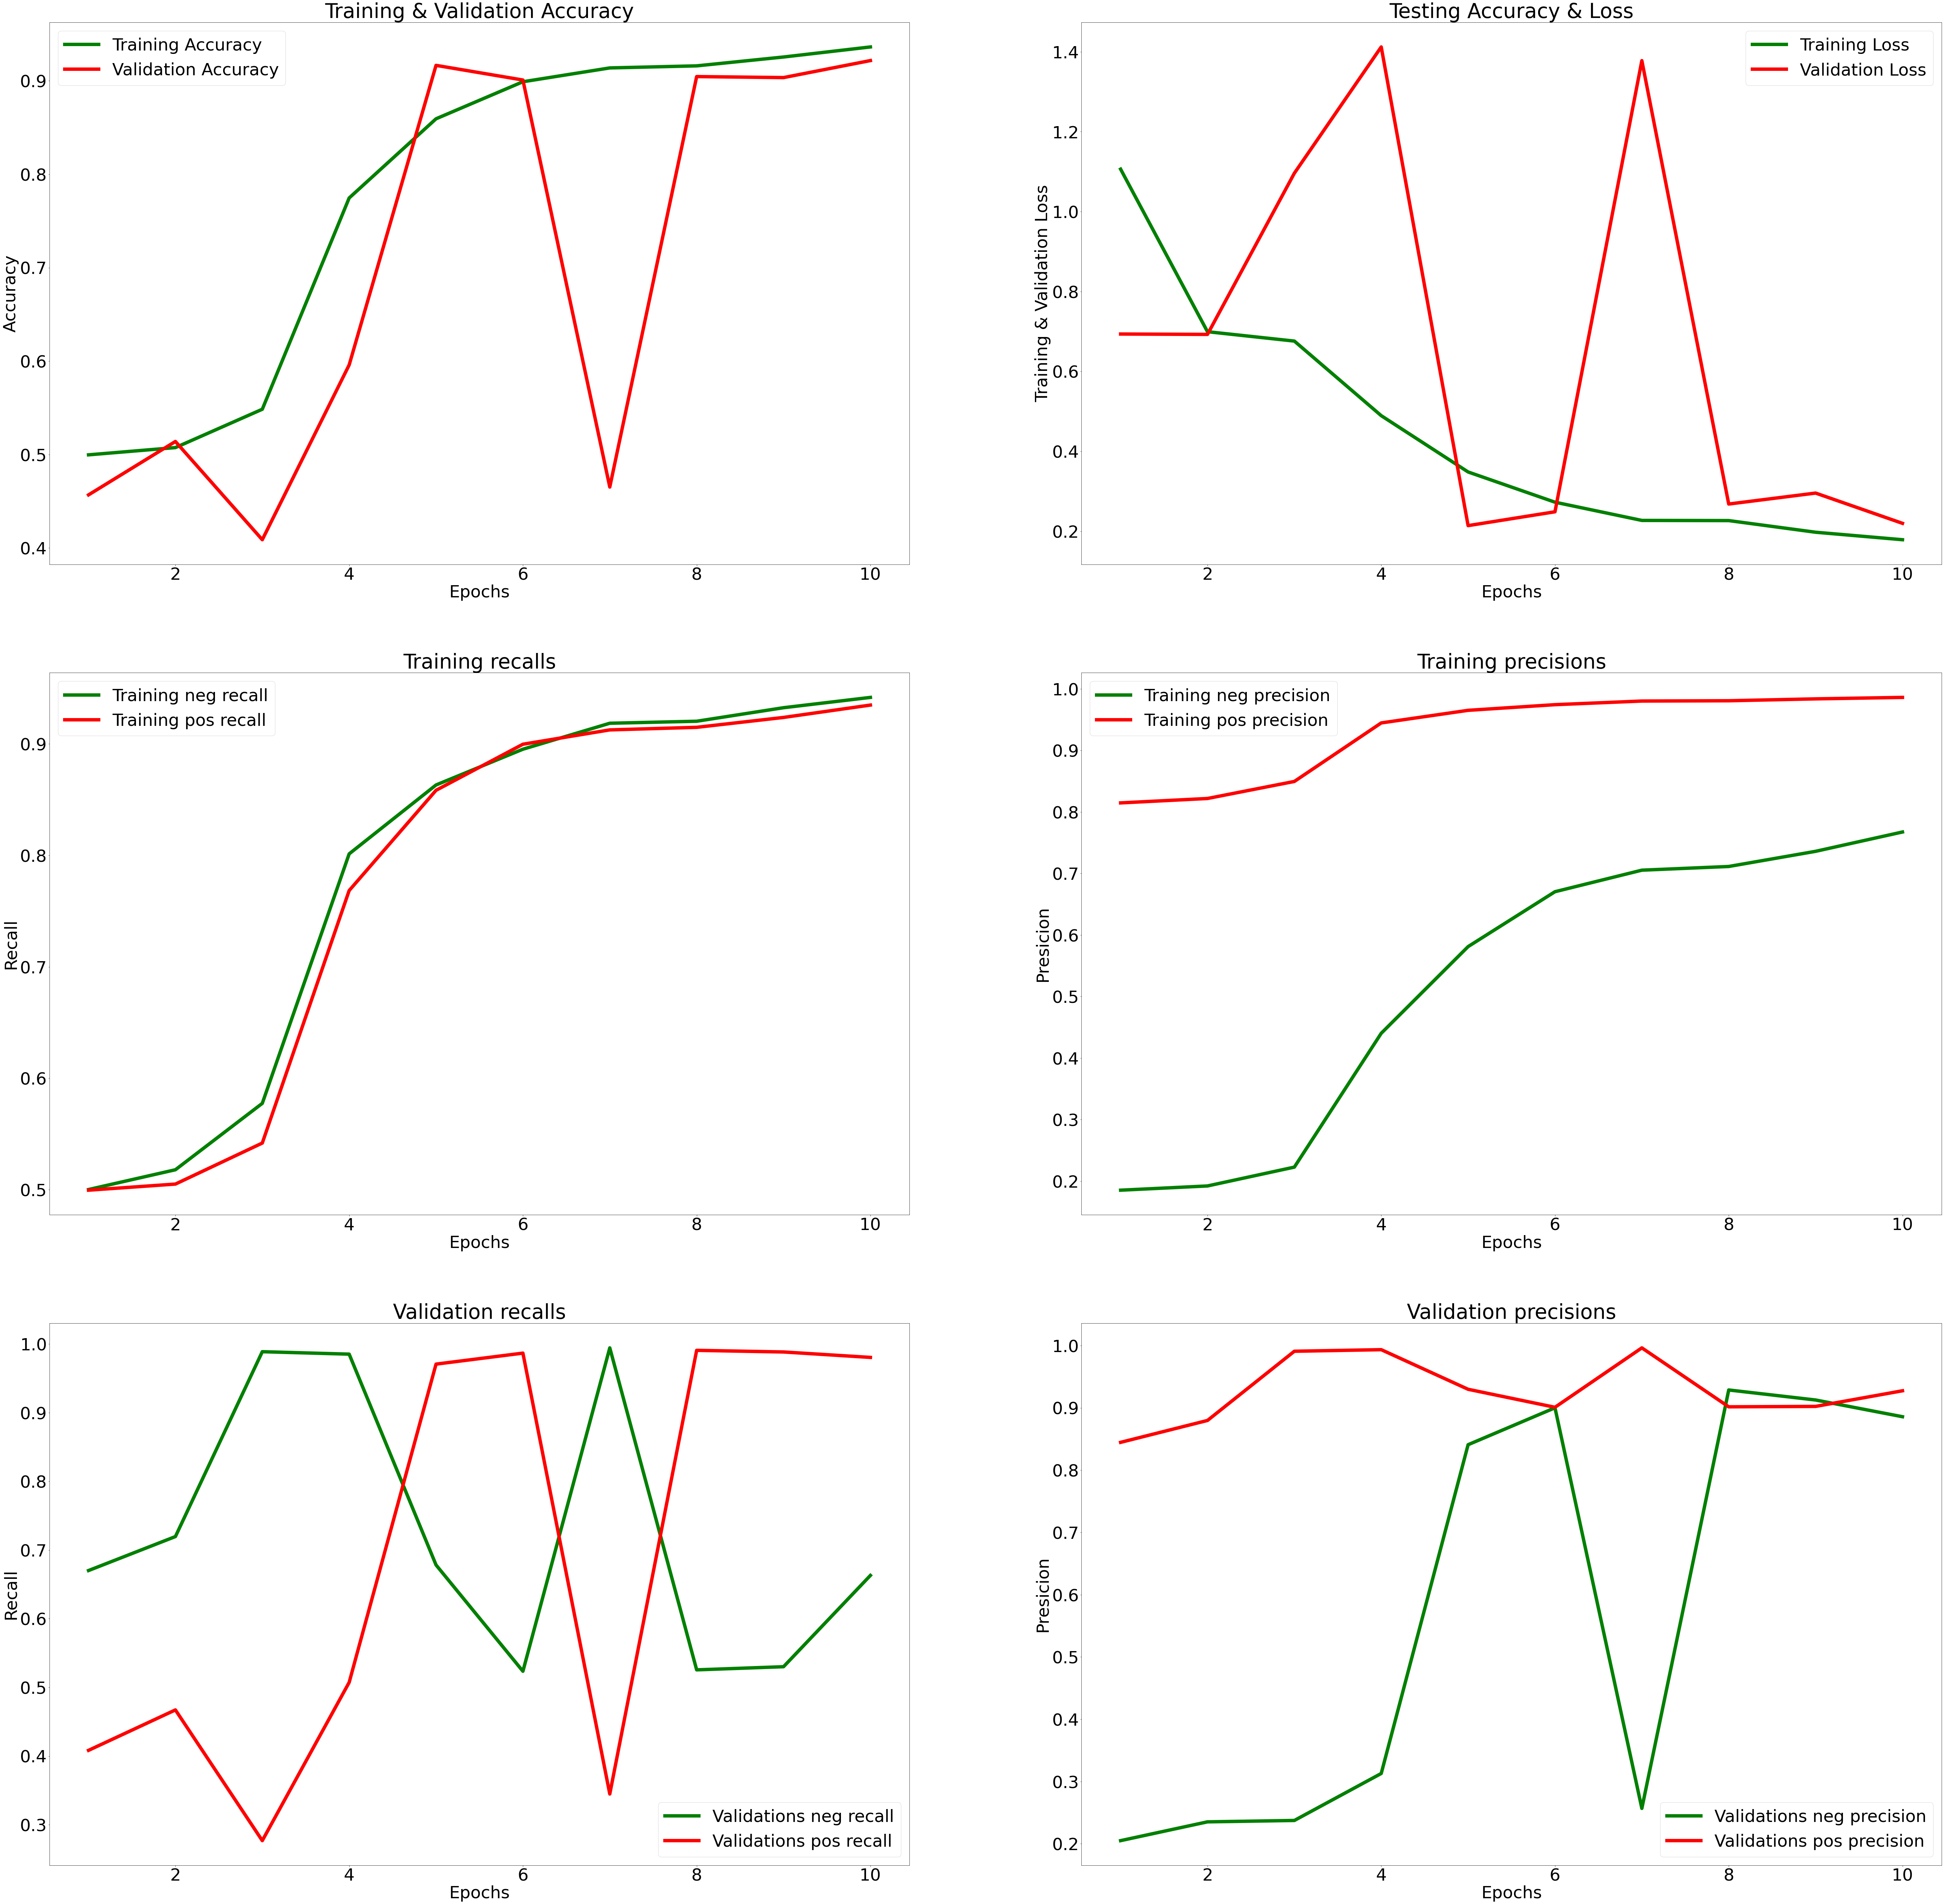

In [29]:
plot_train_info(history.history, 10)

Выводы утешительны: хоть сети и любит назвать положительными негативные отзывы, представляется очевидным, что возможность отличить вышеуказанные классы друг от друга особо труда не составляет